# Hyrax Demonstration

For this demonstration we'll walk through a simplified version of a typical machine learning workflow supported by Hyrax.

In [1]:
%%capture
# Install the Hyrax package if not already installed.
# Note: Hyrax has several large dependencies installation can take a couple of minutes.
%pip install hyrax

In [2]:
import hyrax
import pooch  # We'll use this to retrieve some example Hyper Suprime Cam data from Zenodo
import numpy as np

## Download a sample HSC dataset

In [3]:
file_path = pooch.retrieve(
    # DOI for Example HSC dataset
    url="doi:10.5281/zenodo.14498536/hsc_demo_data.zip",
    known_hash="md5:1be05a6b49505054de441a7262a09671",
    fname="example_hsc_new.zip",
    path="../../data",
    processor=pooch.Unzip(extract_dir="."),
)

This dataset is comprised of approximately 993 cutouts from the Hyper Suprime Cam survey.
Each cutout includes i, r and g bands and is 8 arcseconds on a side.


## Create and configure a Hyrax object

In [4]:
h = hyrax.Hyrax()

An instance of the `Hyrax` class will be used through out this demo.
When working in a notebook, this is how you'll give instructions to Hyrax.

In [5]:
# Select the model to use for training
h.set_config("model.name", "HyraxAutoencoder")

# Set the number of epochs and batch size for training.
h.config["train"]["epochs"] = 20
h.config["data_loader"]["batch_size"] = 32

data_request_definition = {
    "train": {
        "data": {
            "dataset_class": "HSCDataSet",
            "data_location": "../../data/hsc_8asec_1000",
            "primary_id_field": "object_id",
        },
    },
    "infer": {
        "data": {
            "dataset_class": "HSCDataSet",
            "data_location": "../../data/hsc_8asec_1000",
            "primary_id_field": "object_id",
        },
    },
}
h.set_config("data_request", data_request_definition)

/Users/mtauraso/miniforge3/envs/hyrax311/lib/python3.11/site-packages/torch/cuda/__init__.py:65: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


[2026-02-23 16:07:42,113 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.nn.CrossEntropyLoss.


[2026-02-23 16:07:42,113 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.optim.SGD.


[2026-02-23 16:07:42,114 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.optim.lr_scheduler.ExponentialLR.


[2026-02-23 16:07:45,487 hyrax.config_utils:WARNING] Cannot find default_config.toml for umap.UMAP.


[2026-02-23 16:07:45,496 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.nn.CrossEntropyLoss.


[2026-02-23 16:07:45,496 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.optim.SGD.


[2026-02-23 16:07:45,496 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.optim.lr_scheduler.ExponentialLR.


[2026-02-23 16:07:45,497 hyrax.config_utils:WARNING] Cannot find default_config.toml for umap.UMAP.


[2026-02-23 16:07:45,501 hyrax.config_utils:WARNING] Runtime config contains key or section 'data_request' which has no default defined. All configuration keys and sections must be defined in /Users/mtauraso/src/hyrax/src/hyrax/hyrax_default_config.toml


The default configuration needs a few tweaks to work for this demo.
We've updated the location of our sample data, and specified which model we want to train.

In a notebook, the configuration can be modified like a dictionary by editing the `h.config` attribute of the hyrax instance.

## Train a model

In [6]:
h.train()

[2026-02-23 16:07:47,032 hyrax.data_sets.hsc_data_set:INFO] Checking file dimensions to determine standard cutout size...


[2026-02-23 16:07:47,033 hyrax.data_sets.fits_image_dataset:INFO] FitsImageDataSet has 993 objects


[2026-02-23 16:07:47,040 hyrax.data_sets.hsc_data_set:INFO] Processed 993 objects for pruning


[2026-02-23 16:07:47,074 hyrax.data_sets.hsc_data_set:INFO] Checking file dimensions to determine standard cutout size...


[2026-02-23 16:07:47,075 hyrax.data_sets.fits_image_dataset:INFO] FitsImageDataSet has 993 objects


[2026-02-23 16:07:47,082 hyrax.data_sets.hsc_data_set:INFO] Processed 993 objects for pruning


[2026-02-23 16:07:47,091 hyrax.models.model_registry:INFO] Setting model's self.optimizer from config: torch.optim.SGD with arguments: {'lr': 0.01, 'momentum': 0.9}.


[2026-02-23 16:07:47,091 hyrax.models.model_registry:INFO] Setting model's self.criterion from config: torch.nn.CrossEntropyLoss with default arguments.


[2026-02-23 16:07:47,091 hyrax.models.model_registry:INFO] Setting model's self.scheduler from config: torch.optim.lr_scheduler.ExponentialLR
with arguments: {'gamma': 1}.


[2026-02-23 16:07:47,091 hyrax.verbs.train:INFO] Training model: HyraxAutoencoder


[2026-02-23 16:07:47,092 hyrax.verbs.train:INFO] Training dataset(s):
{'train': Name: data (primary dataset)
  Dataset class: HSCDataSet
  Data location: ../../data/hsc_8asec_1000
  Primary ID field: object_id
  Requested fields: dec, dim, filename, filter, image, mask, object_id, ra, rerun, sh, sw, tract, type, variance
, 'infer': Name: data (primary dataset)
  Dataset class: HSCDataSet
  Data location: ../../data/hsc_8asec_1000
  Primary ID field: object_id
  Requested fields: dec, dim, filename, filter, image, mask, object_id, ra, rerun, sh, sw, tract, type, variance
}


2026-02-23 16:07:47,099 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset 'Name: data (primary': 
	{'sampler': <hyrax.pytorch_ignite.SubsetSequentialSampler object at 0x179e0a3d0>, 'batch_size': 32, 'shuffle': False, 'collate_fn': <bound method DataProvider.collate of Name: data (primary dataset)
  Dataset class: HSCDataSet
  Data location: ../../data/hsc_8asec_1000
  Primary ID field: object_id
  Requested fields: dec, dim, filename, filter, image, mask, object_id, ra, rerun, sh, sw, tract, type, variance
>, 'pin_memory': False}


2026-02-23 16:07:47,099 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset 'Name: data (primary': 
	{'sampler': <hyrax.pytorch_ignite.SubsetSequentialSampler object at 0x1245bd7d0>, 'batch_size': 32, 'shuffle': False, 'collate_fn': <bound method DataProvider.collate of Name: data (primary dataset)
  Dataset class: HSCDataSet
  Data location: ../../data/hsc_8asec_1000
  Primary ID field: object_id
  Requested fields: dec, dim, filename, filter, image, mask, object_id, ra, rerun, sh, sw, tract, type, variance
>, 'pin_memory': False}


/Users/mtauraso/miniforge3/envs/hyrax311/lib/python3.11/site-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
2026/02/23 16:07:47 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.


2026/02/23 16:07:47 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

  5%|5         | 1/19 [00:00<?, ?it/s]

[2026-02-23 16:07:58,469 hyrax.pytorch_ignite:INFO] Total training time: 11.29[s]


2026/02/23 16:07:58 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...


2026/02/23 16:07:58 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


[2026-02-23 16:07:58,485 hyrax.verbs.train:INFO] Finished Training


HyraxAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU(approximate='none')
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): GELU(approximate='none')
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): GELU(approximate='none')
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): GELU(approximate='none')
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=9216, out_features=64, bias=True)
  )
  (dec_linear): Sequential(
    (0): Linear(in_features=64, out_features=9216, bias=True)
    (1): GELU(approximate='none')
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): GELU(approximate='none')
    (2): 

When we call `h.train()` to train the model there's a lot going on under the hood:
- The model is automatically loaded onto the fastest hardware available.
- A dataset is instantiated and configured to load batches of data to the same hardware.
- A timestamped directory is created under the configured results directory.
- The configuration becomes immutable and a copy is saved for reproducibility.
- Model and system metrics are logged for review in both TensorBoard and MLFlow.
- Checkpoints are saved automatically.
- Model weights are saved in PyTorch and ONNX formats.

## Run inference

In [7]:
# Increase batch size for faster inference
h.set_config("data_loader.batch_size", 512)

# Run inference
h.infer()

[2026-02-23 16:07:58,490 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.nn.CrossEntropyLoss.


[2026-02-23 16:07:58,490 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.optim.SGD.


[2026-02-23 16:07:58,490 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.optim.lr_scheduler.ExponentialLR.


[2026-02-23 16:07:58,491 hyrax.config_utils:WARNING] Cannot find default_config.toml for umap.UMAP.


[2026-02-23 16:07:58,666 hyrax.data_sets.hsc_data_set:INFO] Checking file dimensions to determine standard cutout size...


[2026-02-23 16:07:58,667 hyrax.data_sets.fits_image_dataset:INFO] FitsImageDataSet has 993 objects


[2026-02-23 16:07:58,674 hyrax.data_sets.hsc_data_set:INFO] Processed 993 objects for pruning


[2026-02-23 16:07:58,708 hyrax.data_sets.hsc_data_set:INFO] Checking file dimensions to determine standard cutout size...


[2026-02-23 16:07:58,709 hyrax.data_sets.fits_image_dataset:INFO] FitsImageDataSet has 993 objects


[2026-02-23 16:07:58,716 hyrax.data_sets.hsc_data_set:INFO] Processed 993 objects for pruning


[2026-02-23 16:07:58,741 hyrax.models.model_registry:INFO] Setting model's self.optimizer from config: torch.optim.SGD with arguments: {'lr': 0.01, 'momentum': 0.9}.


[2026-02-23 16:07:58,741 hyrax.models.model_registry:INFO] Setting model's self.criterion from config: torch.nn.CrossEntropyLoss with default arguments.


[2026-02-23 16:07:58,742 hyrax.models.model_registry:INFO] Setting model's self.scheduler from config: torch.optim.lr_scheduler.ExponentialLR
with arguments: {'gamma': 1}.


[2026-02-23 16:07:58,742 hyrax.verbs.infer:INFO] Inference model: HyraxAutoencoder


[2026-02-23 16:07:58,742 hyrax.verbs.infer:INFO] Inference dataset(s):
{'train': Name: data (primary dataset)
  Dataset class: HSCDataSet
  Data location: ../../data/hsc_8asec_1000
  Primary ID field: object_id
  Requested fields: dec, dim, filename, filter, image, mask, object_id, ra, rerun, sh, sw, tract, type, variance
, 'infer': Name: data (primary dataset)
  Dataset class: HSCDataSet
  Data location: ../../data/hsc_8asec_1000
  Primary ID field: object_id
  Requested fields: dec, dim, filename, filter, image, mask, object_id, ra, rerun, sh, sw, tract, type, variance
}


2026-02-23 16:07:58,742 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset 'Name: data (primary': 
	{'sampler': None, 'batch_size': 512, 'shuffle': False, 'collate_fn': <bound method DataProvider.collate of Name: data (primary dataset)
  Dataset class: HSCDataSet
  Data location: ../../data/hsc_8asec_1000
  Primary ID field: object_id
  Requested fields: dec, dim, filename, filter, image, mask, object_id, ra, rerun, sh, sw, tract, type, variance
>, 'pin_memory': False}


[2026-02-23 16:07:58,754 hyrax.models.model_utils:INFO] Updated config['infer']['model_weights_file'] to: /Users/mtauraso/src/hyrax/docs/pre_executed/results/20260223-160746-train-WKPP/example_model.pth


[2026-02-23 16:07:58,755 hyrax.verbs.infer:INFO] Saving inference results at: /Users/mtauraso/src/hyrax/docs/pre_executed/results/20260223-160758-infer-uv3j


[2026-02-24T00:07:59Z WARN  lance::dataset::write::insert] No existing dataset at /Users/mtauraso/src/hyrax/docs/pre_executed/results/20260223-160758-infer-uv3j/lance_db/results.lance, it will be created


 50%|#####     | 1/2 [00:00<?, ?it/s]

[2026-02-23 16:08:01,127 hyrax.pytorch_ignite:INFO] Total evaluation time: 2.36[s]


[2026-02-23 16:08:01,127 hyrax.data_sets.result_dataset:INFO] Optimizing Lance table after 2 batches


[2026-02-23 16:08:01,130 hyrax.data_sets.result_dataset:INFO] Lance table optimization complete


[2026-02-23 16:08:01,131 hyrax.verbs.infer:INFO] Inference Complete.


Now we can use the trained model weights to run inference.
By default, Hyrax will use the weights of the last successfully trained model.
Different weights can be specified in the configuration.

Before inference we make a small update to the dataset splits by setting `test_size` to 100% and the other splits to 0%.
We also increase the batch size in order to make better use of the available GPU memory.

Finally we run inference over the dataset using the trained model weights with `h.infer()`.
As with training, Hyrax is doing a lot behind the scenes on behalf of the user including:
- Identifying and using the most performant hardware available.
- Creating a new timestamped directory for output.
- Saving a copy of the configuration for reproducibility.
- Storing the results of inference in batched Numpy files.

## Examine an embedding

In [8]:
h.umap()

[2026-02-23 16:08:01,152 hyrax.verbs.umap:INFO] Saving UMAP results to /Users/mtauraso/src/hyrax/docs/pre_executed/results/20260223-160801-umap-Cofu


[2026-02-23 16:08:01,165 hyrax.verbs.umap:INFO] Fitting the UMAP


[2026-02-23 16:08:04,806 hyrax.verbs.umap:INFO] Saving fitted UMAP Reducer


Creating lower dimensional representation using UMAP::   0%|          | 0/2 [00:00<?, ?it/s]

[2026-02-24T00:08:06Z WARN  lance::dataset::write::insert] No existing dataset at /Users/mtauraso/src/hyrax/docs/pre_executed/results/20260223-160801-umap-Cofu/lance_db/results.lance, it will be created


[2026-02-23 16:08:06,800 hyrax.data_sets.result_dataset:INFO] Optimizing Lance table after 2 batches


[2026-02-23 16:08:06,804 hyrax.data_sets.result_dataset:INFO] Lance table optimization complete


[2026-02-23 16:08:06,804 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP


Here `h.umap()` will use the output of the latest inference operation to inform a UMAP fitter and create a lower dimensional representation of the inference results.

Hyrax ensures that file output of the inference step allows for efficient fitting and transformation with UMAP and all of the data plumbing to read from inference and write results is taken care of automatically.

## Interactive visualization

[2026-02-23 16:08:06,809 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.nn.CrossEntropyLoss.


[2026-02-23 16:08:06,809 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.optim.SGD.


[2026-02-23 16:08:06,809 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.optim.lr_scheduler.ExponentialLR.


[2026-02-23 16:08:06,810 hyrax.config_utils:WARNING] Cannot find default_config.toml for umap.UMAP.


[2026-02-23 16:08:07,753 hyrax.verbs.visualize:INFO] UMAP directory not specified at runtime. Reading from config values.


[2026-02-23 16:08:07,790 hyrax.data_sets.hsc_data_set:INFO] Checking file dimensions to determine standard cutout size...


[2026-02-23 16:08:07,791 hyrax.data_sets.fits_image_dataset:INFO] FitsImageDataSet has 993 objects


[2026-02-23 16:08:07,799 hyrax.data_sets.hsc_data_set:INFO] Processed 993 objects for pruning


[2026-02-23 16:08:07,833 hyrax.data_sets.hsc_data_set:INFO] Checking file dimensions to determine standard cutout size...


[2026-02-23 16:08:07,834 hyrax.data_sets.fits_image_dataset:INFO] FitsImageDataSet has 993 objects


[2026-02-23 16:08:07,842 hyrax.data_sets.hsc_data_set:INFO] Processed 993 objects for pruning


[2026-02-23 16:08:07,842 hyrax.verbs.visualize:WARNING] Field ra is unavailable for this dataset


[2026-02-23 16:08:07,842 hyrax.verbs.visualize:WARNING] Field dec is unavailable for this dataset


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
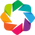

:Layout
   .DynamicMap.I  :DynamicMap   []
      :Points   [x,y]
   .DynamicMap.II :DynamicMap   []
      :Table   [object_id]   (x,y)

In [9]:
h.set_config("visualize.fields", ["ra", "dec"])
viz = h.visualize(width=1000, height=1000)

The Hyrax visualization tooling utilizes Holoviews, Datashader as well as an efficient tree structure to be able to display millions of points.
It allows for panning, zooming as well as lasso and box selections.
When selecting points, the resulting object ids are displayed are displayed in the associated table.

While this is an early version of interactive visualization, it has been scaled up to millions of data points.
The next steps for this tooling will be to support deeper interactivity, namely:
-  Automatically displaying the object selected in the table
-  Leveraging a vector db to identify similar objects
-  Supporting three dimensional UMAP output


This visualization runs in a notebook but when rendered to HTML (for demonstration or documentation) the server backing the interactive visual isn't packaged with the rendering. If the cell above was run locally, the resulting UI would look similar to the following screen shot.

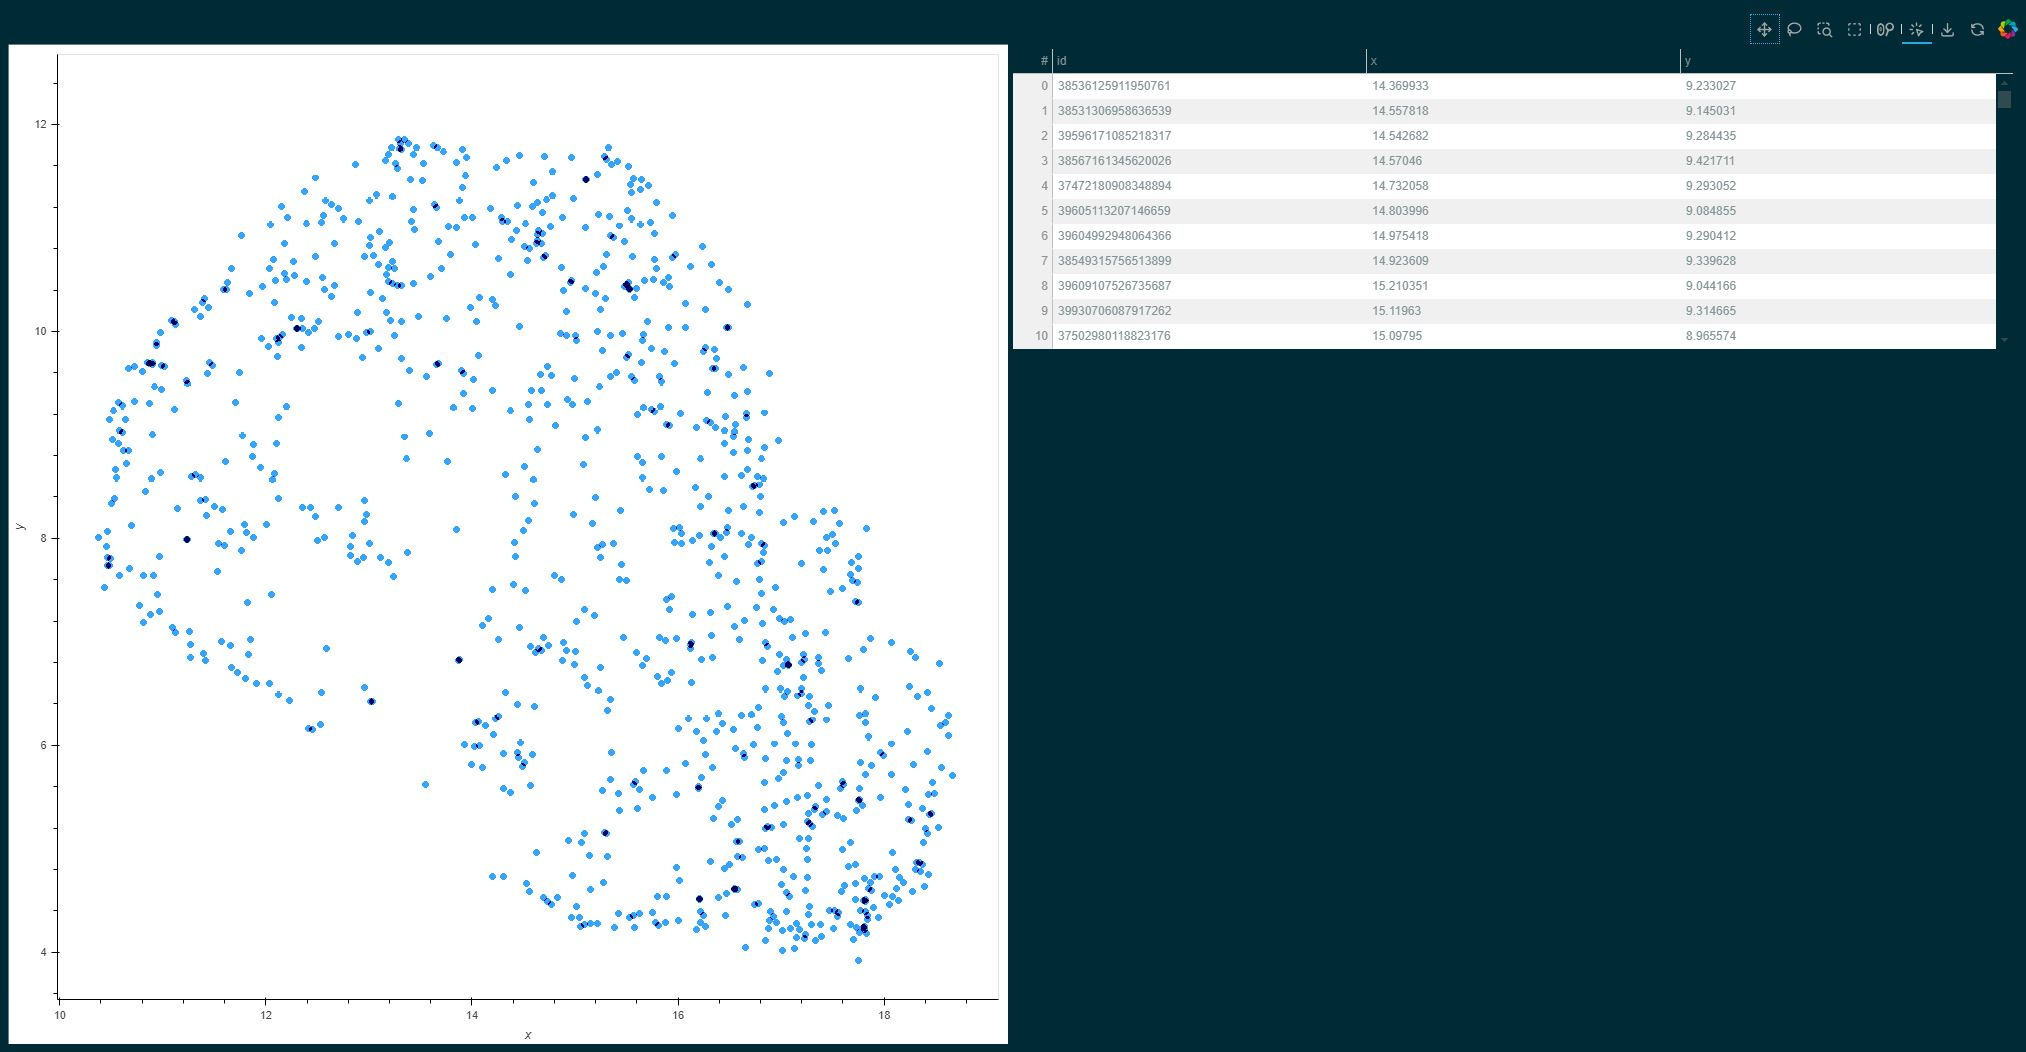


## Create a vector database
By calling `h.save_to_database()`, we can populate a vector database for efficient similarity searching of the inference results.

In [10]:
h.save_to_database()

[2026-02-23 16:08:09,843 hyrax.verbs.save_to_database:INFO] Saving vector database at /Users/mtauraso/src/hyrax/docs/pre_executed/results/20260223-160809-vector-db-KCC8


  0%|                                                                                                                                                                                                                                                                                                       | 0/2 [00:00<?, ?it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 1/2 [00:00<00:00,  4.15it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.34it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.31it/s]


[2026-02-23 16:08:10,403 hyrax.verbs.save_to_database:INFO] Vector database insertion complete. Total time: 0.038s for 2 batches


## Perform a similarity search

To search for objects that are similar to a given object, we can exploit the efficiency of the vector database that was just created. Here, we establish a connection to the ChromaDB database that was just created using `h.database_connection()`.

In [11]:
db = h.database_connection()

With an object id, we can search for k nearest neighbors. In this example, we provide an id for an object in the database and request the 5 nearest neighbors in order of increasing distance.

Note: Because the randomly selected object id _is in_ the database the closest "neighbor" is the object itself. Thus the nearest neighbor that is not the original object, is the second element in the returned list.

In [12]:
search_object_id = "37498028021538822"

search_results = db.search_by_id(search_object_id, k=5)

for k, v in search_results.items():
    print(f"Results for ID {k}:\n{v}")

Results for ID 37498028021538822:
['37498028021538822', '37489932008188806', '36424921852690051', '38562926507872143', '39991600134250664']


## Display the objects
Let's check that the nearest neighbor seems reasonable. We'll plot the original object, and then the nearest neighbors for visual comparison. To plot the images we'll need to get some information from our dataset.

Using `h.prepare()` we get an instance of the original HSC dataset class, and use that to get the list of object ids.

In [13]:
hsc_dataset = h.prepare()["infer"]
all_ids = list(hsc_dataset.ids())

[2026-02-23 16:08:10,467 hyrax.data_sets.hsc_data_set:INFO] Checking file dimensions to determine standard cutout size...


[2026-02-23 16:08:10,468 hyrax.data_sets.fits_image_dataset:INFO] FitsImageDataSet has 993 objects


[2026-02-23 16:08:10,475 hyrax.data_sets.hsc_data_set:INFO] Processed 993 objects for pruning


[2026-02-23 16:08:10,510 hyrax.data_sets.hsc_data_set:INFO] Checking file dimensions to determine standard cutout size...


[2026-02-23 16:08:10,511 hyrax.data_sets.fits_image_dataset:INFO] FitsImageDataSet has 993 objects


[2026-02-23 16:08:10,518 hyrax.data_sets.hsc_data_set:INFO] Processed 993 objects for pruning


[2026-02-23 16:08:10,519 hyrax.prepare:INFO] Finished Prepare


We can use the nearest neighbor ids returned from the vector database search to get the original images from the `hsc_dataset` and then plot those for comparison.

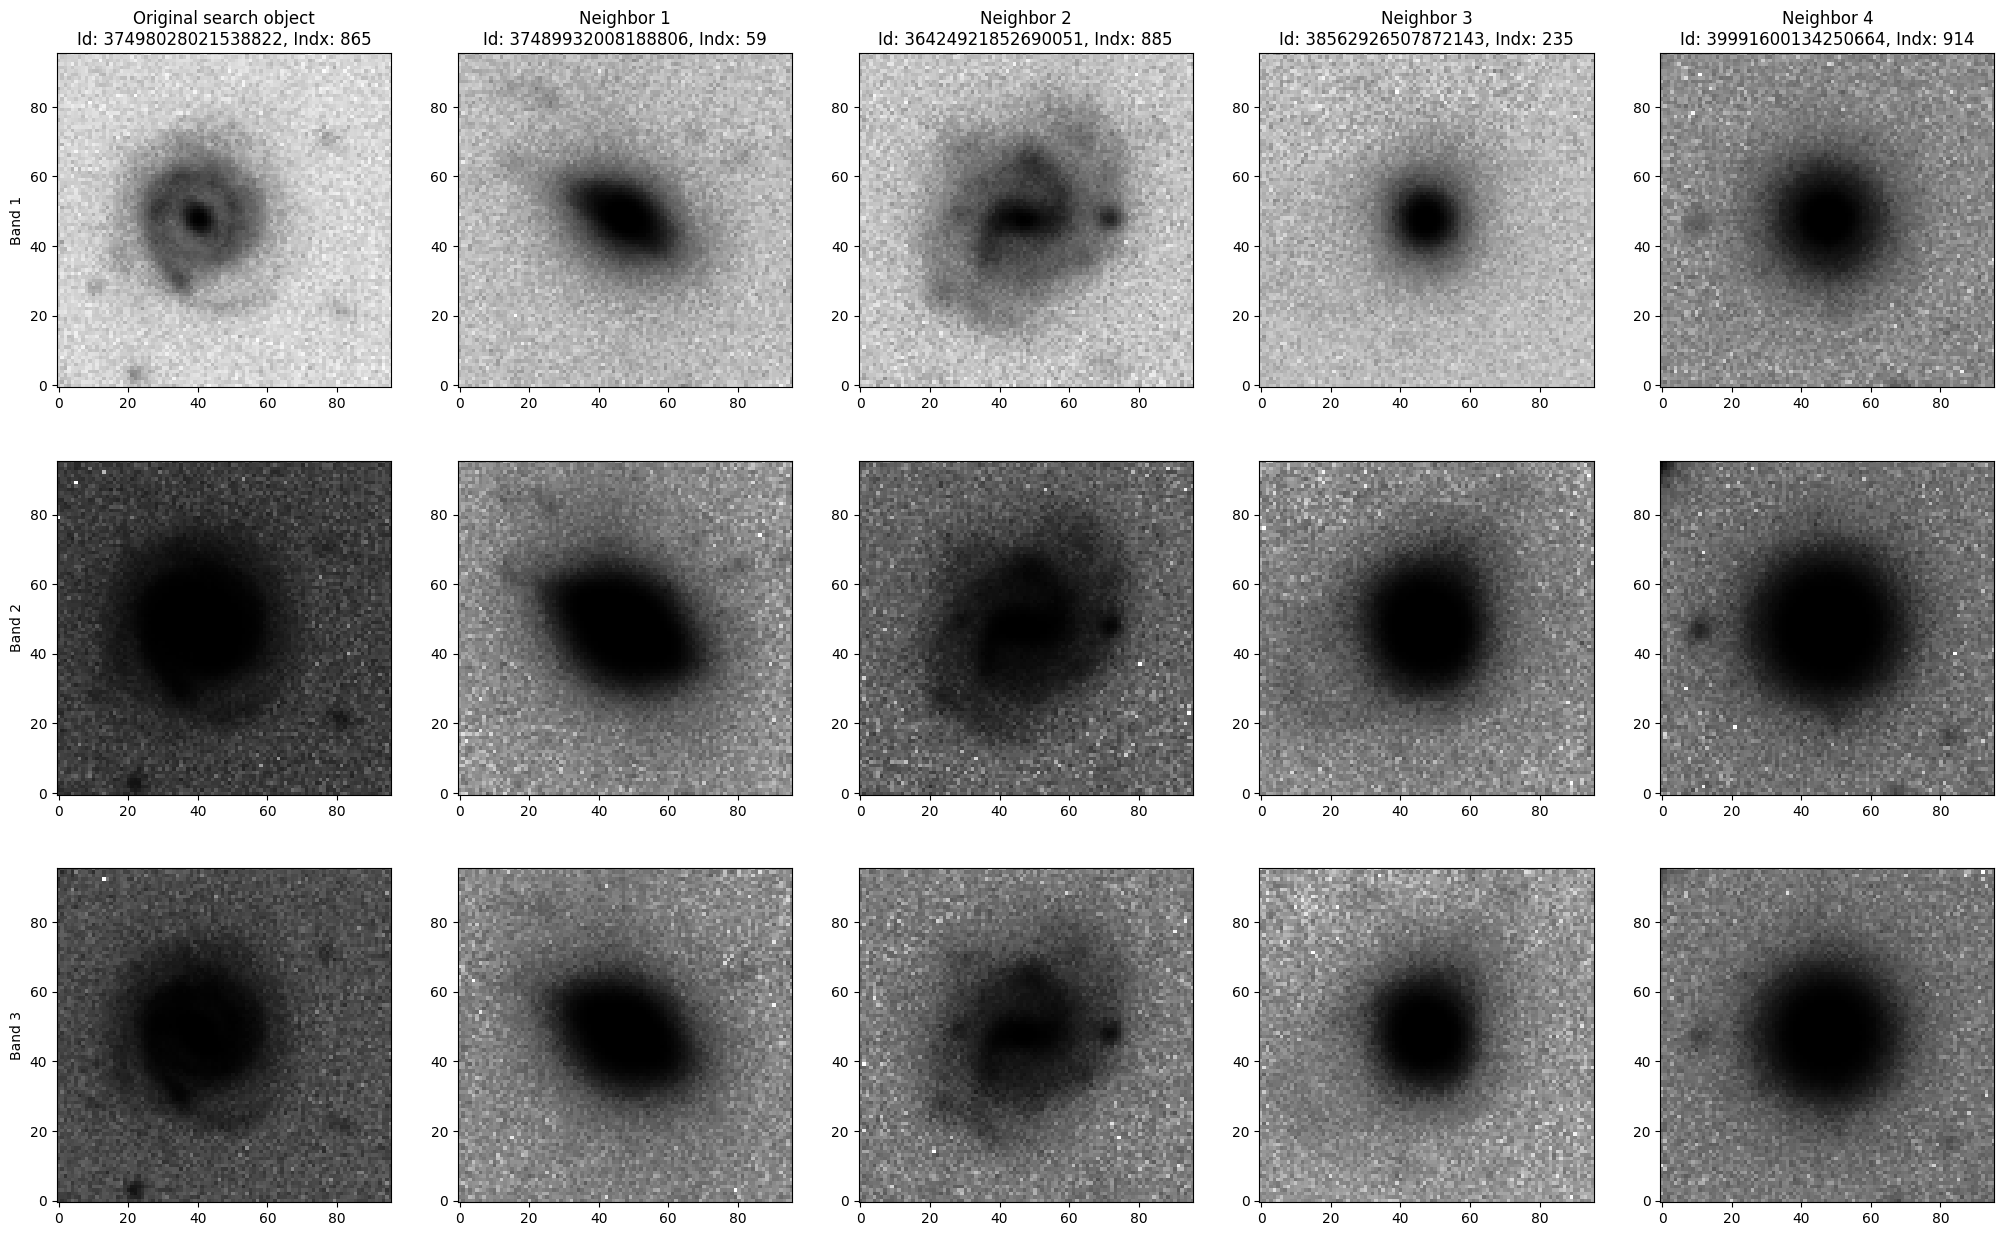

In [14]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(3, 5, figsize=(25, 5 * 3))

for ni, r in enumerate(search_results[search_object_id]):
    indx = all_ids.index(r)  # Get the index of the object in the dataset
    data = hsc_dataset[indx]["data"]["image"]  # Retrieve the data for the object - a (3, 96, 96) numpy array
    data = (data - np.min(data)) / (np.max(data) - np.min(data))  # Normalize the data

    for i in range(3):
        axes[i, ni].imshow(data[i], origin="lower", norm=LogNorm(), cmap="Greys")

        if i == 0:
            if ni == 0:
                axes[i, ni].set_title(f"Original search object\nId: {search_object_id}, Indx: {indx}")
            else:
                axes[i, ni].set_title(f"Neighbor {ni}\nId: {r}, Indx: {indx}")

        if ni == 0:
            axes[i, ni].set_ylabel(f"Band {i + 1}")

In the left column are three bands of the original image that we used for similarity search.
The remaining 4 columns are the first few nearest neighbors.